Esta es una adaptación de un modelo modilarizado que se puede encontra documentado en: https://github.com/ManuelLagunas/Telecom.git

___

Hola Manuel!

Mi nombre es Matias y voy a estar revisando tu proyecto.

En la primer revision, de encontrar errores voy a estar marcandotelos para que puedas corregirlos por tu cuenta. Lo mas parecido a una situacion real de trabajo como DA. De haber posteriores revisiones ire brindandote mayor soporte para sacar adelante el proyecto.

Encontraras mis comentarios debajo - **por favor no los muevas, modifiques o elimines**.

Encontraras mis comentarios en verde, amarillo o rojo de esta manera:

<div class="alert alert-block alert-success">
<b>Comentario de Revisor</b> <a class="tocSkip"></a>

Genial, buen trabajo.
</div>

<div class="alert alert-block alert-warning">
<b>Comentario de Revisor</b> <a class="tocSkip"></a>

Cuidado, se recomienda...
</div>

<div class="alert alert-block alert-danger">

<b>Comentario de Revisor</b> <a class="tocSkip"></a>

Necesita correcion. El trabajo no puede ser aceptado si precisa correcion.
</div>

Puedes responder a mis comentarios utilizando un mensaje de este tipo:

<div class="alert alert-block alert-info">
<b>Respuesta de estudiante.</b> <a class="tocSkip"></a>
</div>

___

In [1]:
# Libraries ----------------------------------------

import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from lightgbm import LGBMClassifier

warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore', category=UserWarning, module='sklearn')
warnings.filterwarnings('ignore', category=UserWarning, module='lightgbm')

In [2]:
# Loading data ----------------------------------------

contract_raw = pd.read_csv("/datasets/final_provider/contract.csv")
internet_raw = pd.read_csv("/datasets/final_provider/internet.csv")
personal_raw = pd.read_csv("/datasets/final_provider/personal.csv")
phone_raw = pd.read_csv("/datasets/final_provider/phone.csv")

## Corrección de errores

In [3]:
# Correct name columns ----------------------------------------

def snake_case_columns(df):
    df.columns = df.columns.map(lambda x: re.sub(r'(?<=[a-z])(?=[A-Z])', '_', x).lower())
    return df

contract_df = snake_case_columns(contract_raw)
internet_df = snake_case_columns(internet_raw)
personal_df = snake_case_columns(personal_raw)
phone_df = snake_case_columns(phone_raw)

In [4]:
# Correct columns dtype ----------------------------------------

#-------- contract_df --------
contract_df['begin_date'] = pd.to_datetime(contract_df['begin_date'])
contract_df['begin_date'] = (contract_df['begin_date'] - contract_df['begin_date'].min()).dt.days
contract_df['end_date'] = contract_df['end_date'].apply(lambda x: 0 if x == 'No' else 1)
contract_df = pd.get_dummies(contract_df, columns=['type'], prefix='type', drop_first=True)
contract_df = pd.get_dummies(contract_df, columns=['paperless_billing'], prefix='paperless_billing', drop_first=True)
contract_df = pd.get_dummies(contract_df, columns=['payment_method'], prefix='payment_method', drop_first=True)
contract_df['total_charges'] = pd.to_numeric(contract_df['total_charges'], errors='coerce')
# contract_df.info()

In [5]:
#-------- internet_df --------
cols_to_encode = [col for col in internet_df.columns if col not in ['customer_id']]
internet_df = pd.get_dummies(internet_df, columns=cols_to_encode, drop_first=True)
# internet_df.info()

In [6]:
#-------- personal_df --------
cols_to_encode = [col for col in personal_df.columns if col not in ['customer_id', 'senior_citizen']]
personal_df = pd.get_dummies(personal_df, columns=cols_to_encode, drop_first=True)
personal_df['senior_citizen'] = personal_df['senior_citizen'].astype('bool')
# personal_df.info()

In [7]:
#-------- phone_df --------
phone_df = pd.get_dummies(phone_df, columns=['multiple_lines'], prefix='multiple_lines', drop_first=True)
# phone_df.info()

## Fusión de dataframes

In [8]:
# Dataframes fusion ----------------------------------------

merged_df = pd.merge(contract_df, internet_df, on='customer_id', how='outer')
merged_df = pd.merge(merged_df, personal_df, on='customer_id', how='outer')
merged_df = pd.merge(merged_df, phone_df, on='customer_id', how='outer')

In [9]:
# Fill missing values ----------------------------------------

merged_df['total_charges'].dropna(inplace=True)
merged_df.fillna(False, inplace=True)

In [10]:
# Correct columns dtype ----------------------------------------

# merged_df['begin_date'] = pd.to_datetime(merged_df['begin_date'])
merged_df['end_date'] = pd.to_numeric(merged_df['end_date'], errors='coerce')
merged_df['total_charges'] = pd.to_numeric(merged_df['total_charges'], errors='coerce')

## Estudio de desbalanceo de clases

In [11]:
# Check unbalanced data ----------------------------------------

# Count the number of 1s and 0s in the 'end_date' column
count_1 = merged_df['end_date'].eq(1).sum()
count_0 = merged_df['end_date'].eq(0).sum()

# Print the counts
print("Number of 1s:", count_1)
print("Number of 0s:", count_0)

Number of 1s: 1869
Number of 0s: 5174


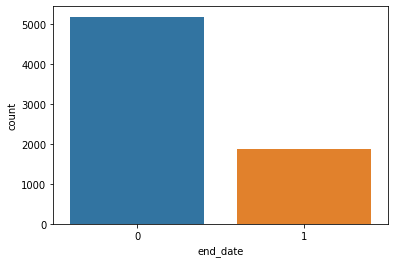

In [12]:
# Plotting data ----------------------------------------
sns.countplot(data=merged_df, x='end_date')
plt.show()

In [13]:
# Calculate the percentage of 1s and 0s in the 'end_date' column
percentage_1 = count_1 / len(merged_df) * 100
percentage_0 = count_0 / len(merged_df) * 100

# Print the percentages
print("Percentage of 1s:", percentage_1)
print("Percentage of 0s:", percentage_0)

Percentage of 1s: 26.536987079369588
Percentage of 0s: 73.4630129206304


In [14]:
# Calculate the ratio of 0s to 1s in the 'end_date' column
ratio_0_to_1 = count_0 / count_1
# Print the ratio
print("Ratio of 0s to 1s:", ratio_0_to_1)

Ratio of 0s to 1s: 2.7683253076511503


## Creación de características y objetivo

In [15]:
# features creation ----------------------------------------

# df.columns
features = merged_df.drop(columns=['customer_id', 'end_date'], axis=1)

In [16]:
# target creation ----------------------------------------

target = merged_df['end_date']

## Creación de conjunto de datos

In [17]:
# Split data ----------------------------------------

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=42)

In [18]:
cols_to_convert = ['type_One year', 'type_Two year', 'paperless_billing_Yes',
                   'payment_method_Credit card (automatic)',
                   'payment_method_Electronic check', 'payment_method_Mailed check',
                   'internet_service_Fiber optic', 'online_security_Yes',
                   'online_backup_Yes', 'device_protection_Yes', 'tech_support_Yes',
                   'streaming_tv_Yes', 'streaming_movies_Yes', 'senior_citizen',
                   'gender_Male', 'partner_Yes', 'dependents_Yes', 'multiple_lines_Yes']

features_train[cols_to_convert] = features_train[cols_to_convert].astype(bool)
features_test[cols_to_convert] = features_test[cols_to_convert].astype(bool)

<div class="alert alert-block alert-success">
<b>Comentario de Revisor</b> <a class="tocSkip"></a>

Excelente comienzo Manuel
    
Gran trabajo con el preprocesmaiento de los diferentes datasets y formando un dataframe combinado para entrenar los clasificadores
    
Bien hecho caracterizando el desbalance de la variable ovjetivo
    
Y tambien con el split de tu dataframe combinado
</div>

<div class="alert alert-block alert-warning">
<b>Comentario de Revisor</b> <a class="tocSkip"></a>

Sospecho que trabajaste en tu local y luego cargaste el proyecto al server de Tripleten, porque hay cosas que estan fallando y lo hubieras detectado y solucionado si hubieras testeado el funcionamiento en nuestro server
    
Ademas a modo de sugerencia, o bajamos el parametro de max iterations para los entrenamiento o sumamos un bloque de codigo para ignorar las warning 
    
Ultima sugerencia, podrias sumar un EDA para identificar cuales features vale la pena usar para el entrenamiento de los clasificadores. Por lo pronto eliminaste algunas, aplicaste OHE a otras y calculaste algunas vo
</div>

<div class="alert alert-block alert-danger">
<b>Comentario de Revisor</b> <a class="tocSkip"></a>

Tu funcion de upsample esta fallando debes corregirla, no asi con la de downsample esa si funciona bien
    
Algunos modelos estan corriendo bien y otros fallan, deberias arreglar eso
</div>

<div class="alert alert-block alert-info">
<b>Comentario de Revisor</b> <a class="tocSkip"></a>

Si bien no puedo arobar tu proyecto dado que hay cosas que no estan corriendo
    
Quiero remarcar que tu notebook esta impecable, documentada y organizada de gran manera y la forma en que encaraste cada modelo es genial
</div>

___

<div class="alert alert-block alert-success">
<b>Comentario de Revisor - 2da ITERACION</b> <a class="tocSkip"></a>

Muy bien Manuel, veo que optaste por sumar el codigo para ignorar las warning de iteracion de skLearn
    
Corregiste tambien las funciones de up y down sample, genial
    
El EDA no lo agregaste, pero voy a dar por sentado que para el preprocesamiento y feature engineering tuviste que analizar minimamente los datos de partida
</div>

## Sobremuestreo

In [19]:
# Upsampler creation ---------------------------------------- 

def upsample(features, target):
    # Convert target to a pandas Series if it's a one-column DataFrame
    if isinstance(target, pd.DataFrame):
        target = target.squeeze()

    # Combine features and target
    df = pd.concat([features, target], axis=1)

    # Class separation
    df_majority = df[target==0]
    df_minority = df[target==1]

    # Upsampling the minority class
    df_minority_upsampled = resample(df_minority, 
                                     replace=True,     
                                     n_samples=len(df_majority),    
                                     random_state=123) 

    # Combine the majority class with the minority upsampled class
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])

    # Shuffle the data
    df_upsampled = df_upsampled.sample(frac=1, random_state=123)

    # Separate features and target
    features_upsampled = df_upsampled.drop(target.name, axis=1)
    target_upsampled = df_upsampled[target.name]

    return features_upsampled, target_upsampled

In [20]:
# Upsampling ----------------------------------------

features_train_upsampled, target_train_upsampled = upsample(features_train, target_train)

In [21]:
features_train_upsampled[cols_to_convert] = features_train_upsampled[cols_to_convert].astype(bool)

## Submuestreo

In [22]:
# Downsampler creation ----------------------------------------

def downsample(features, target):
    # Convert target to a pandas Series if it's a one-column DataFrame
    if isinstance(target, pd.DataFrame):
        target = target.squeeze()

    # Combine features and target
    df = pd.concat([features, target], axis=1)

    # Class separation
    df_majority = df[target==0]
    df_minority = df[target==1]

    # Calculate the fraction of majority samples to keep
    fraction = len(df_minority) / len(df_majority)

    # Downsample the majority class
    df_majority_downsampled = df_majority.sample(frac=fraction, random_state=123)

    # Combine the minority class with the downsampled majority class
    df_downsampled = pd.concat([df_majority_downsampled, df_minority])

    # Shuffle the data
    df_downsampled = df_downsampled.sample(frac=1, random_state=123)

    # Separate features and target
    features_downsampled = df_downsampled.drop(target.name, axis=1)
    target_downsampled = df_downsampled[target.name]

    return features_downsampled, target_downsampled

In [23]:
# Downsampling ----------------------------------------

features_train_downsampled, target_train_downsampled = downsample(features_train, target_train)

## Modelos de control

In [24]:
# Tuning models ----------------------------------------

# ---------------- Logistic Regression ----------------
# Define the hyperparameters grid
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga']
}

# Create the logistic regression model
logreg = LogisticRegression()

# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=logreg, param_grid=param_grid, scoring='roc_auc', cv=5)

# Fit the model to the training data
grid_search.fit(features_train, target_train)

# Get the best hyperparameters and the corresponding AUC-ROC score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the best hyperparameters and the corresponding AUC-ROC score
print("Best Hyperparameters:", best_params)
print("Best AUC-ROC Score:", best_score)

Best Hyperparameters: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Best AUC-ROC Score: 0.8300174016434296


In [25]:
# ---------------- Random Forest ----------------
# Define the hyperparameters grid
param_grid = {
    'n_estimators': [10, 20, 30],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Create the random forest model
rf = RandomForestClassifier()

# Create scorer
auc_roc_scorer = make_scorer(roc_auc_score)

# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=rf, param_grid=param_grid, scoring=auc_roc_scorer, cv=5, n_jobs=-1)

# Fit the model to the training data
grid_search.fit(features_train, target_train)

# Get the best hyperparameters and the corresponding AUC-ROC score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the best hyperparameters and the corresponding AUC-ROC score
print("Best Hyperparameters:", best_params)
print("Best AUC-ROC Score:", best_score)

Best Hyperparameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 20}
Best AUC-ROC Score: 0.7486367672001835


In [26]:
# ---------------- LightGBM ----------------
# Define the hyperparameters grid
param_grid = {
    'n_estimators': [10, 20, 30],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [None, 10, 20, 30],
    'num_leaves': [31, 62, 93],
    'min_child_samples': [20, 30, 40]
}

# Create the LightGBM model
lgbm = LGBMClassifier()

# Create scorer
auc_roc_scorer = make_scorer(roc_auc_score)

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, scoring=auc_roc_scorer, cv=5, n_jobs=-1)

# Fit the model to the training data
grid_search.fit(features_train, target_train)

# Get the best hyperparameters and the corresponding AUC-ROC score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the best hyperparameters and the corresponding AUC-ROC score
print("Best Hyperparameters:", best_params)
print("Best AUC-ROC Score:", best_score)

Best Hyperparameters: {'learning_rate': 0.2, 'max_depth': None, 'min_child_samples': 20, 'n_estimators': 30, 'num_leaves': 93}
Best AUC-ROC Score: 0.815336804941176


<div class="alert alert-block alert-success">
<b>Comentario de Revisor - 2da ITERACION</b> <a class="tocSkip"></a>

Excelente Manuel el entrenamiento post busqueda de hyper params optimos de tus clasificadore sin aplicar up ni down sample
</div>

## Modelos con balanceo

In [27]:
# Tuning models ----------------------------------------

# ---------------- Logistic Regression ----------------
# Define the hyperparameters grid
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
    'class_weight': ['balanced']
}

# Create the logistic regression model
logreg = LogisticRegression()

# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=logreg, param_grid=param_grid, scoring='roc_auc', cv=5)

# Fit the model to the training data
grid_search.fit(features_train, target_train)

# Get the best hyperparameters and the corresponding AUC-ROC score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the best hyperparameters and the corresponding AUC-ROC score
print("Best Hyperparameters:", best_params)
print("Best AUC-ROC Score:", best_score)

Best Hyperparameters: {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}
Best AUC-ROC Score: 0.8299967114032473


In [28]:
# ---------------- Random Forest ----------------
# Define the hyperparameters grid
param_grid = {
    'n_estimators': [10, 20, 30],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', 'balanced_subsample']
}

# Create the random forest model
rf = RandomForestClassifier()

# Create scorer
auc_roc_scorer = make_scorer(roc_auc_score)

# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=rf, param_grid=param_grid, scoring=auc_roc_scorer, cv=5, n_jobs=-1)

# Fit the model to the training data
grid_search.fit(features_train, target_train)

# Get the best hyperparameters and the corresponding AUC-ROC score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the best hyperparameters and the corresponding AUC-ROC score
print("Best Hyperparameters:", best_params)
print("Best AUC-ROC Score:", best_score)

Best Hyperparameters: {'class_weight': 'balanced_subsample', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 20}
Best AUC-ROC Score: 0.7862543481257906


In [29]:
# ---------------- LightGBM ----------------
# Define the hyperparameters grid
param_grid = {
    'n_estimators': [10, 20, 30],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [None, 10, 20, 30],
    'num_leaves': [31, 62, 93],
    'min_child_samples': [20, 30, 40],
    'class_weight': ['balanced']
}

# Create the LightGBM model
lgbm = LGBMClassifier()

# Create scorer
auc_roc_scorer = make_scorer(roc_auc_score)

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, scoring=auc_roc_scorer, cv=5, n_jobs=-1)

# Fit the model to the training data
grid_search.fit(features_train, target_train)

# Get the best hyperparameters and the corresponding AUC-ROC score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the best hyperparameters and the corresponding AUC-ROC score
print("Best Hyperparameters:", best_params)
print("Best AUC-ROC Score:", best_score)

# Create the best model ----------------------------------------

lgbm_balanced = LGBMClassifier(**best_params)
lgbm_balanced.fit(features_train, target_train)

Best Hyperparameters: {'class_weight': 'balanced', 'learning_rate': 0.2, 'max_depth': None, 'min_child_samples': 30, 'n_estimators': 30, 'num_leaves': 93}
Best AUC-ROC Score: 0.8370737896583412


LGBMClassifier(class_weight='balanced', learning_rate=0.2, max_depth=None,
               min_child_samples=30, n_estimators=30, num_leaves=93)

## Modelos con sobremuestreo

In [30]:
# Tuning models ----------------------------------------

# ---------------- Logistic Regression ----------------
# Define the hyperparameters grid
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga']
}

# Create the logistic regression model
logreg = LogisticRegression()

# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=logreg, param_grid=param_grid, scoring='roc_auc', cv=5)

# Fit the model to the training data
grid_search.fit(features_train_upsampled, target_train_upsampled)

# Get the best hyperparameters and the corresponding AUC-ROC score
best_params_lr = grid_search.best_params_
best_score_lr = grid_search.best_score_

# Print the best hyperparameters and the corresponding AUC-ROC score
print("Best Hyperparameters:", best_params_lr)
print("Best AUC-ROC Score:", best_score_lr)

Best Hyperparameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Best AUC-ROC Score: 0.8367971405336718


In [31]:
# ---------------- Random Forest ----------------
# Define the hyperparameters grid
param_grid = {
    'n_estimators': [10, 20, 30],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Create the random forest model
rf = RandomForestClassifier()

# Create scorer
auc_roc_scorer = make_scorer(roc_auc_score)

# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=rf, param_grid=param_grid, scoring=auc_roc_scorer, cv=5, n_jobs=-1)

# Fit the model to the training data
grid_search.fit(features_train_upsampled, target_train_upsampled)

# Get the best hyperparameters and the corresponding AUC-ROC score
best_params_rf = grid_search.best_params_
best_score_rf = grid_search.best_score_

# Print the best hyperparameters and the corresponding AUC-ROC score
print("Best Hyperparameters:", best_params_rf)
print("Best AUC-ROC Score:", best_score_rf)

Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}
Best AUC-ROC Score: 0.9251005672686953


In [32]:
# Create the LightGBM model
lgbm = LGBMClassifier()

# Create scorer
auc_roc_scorer = make_scorer(roc_auc_score)

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, scoring=auc_roc_scorer, cv=5, n_jobs=-1)

# Fit the model to the training data
grid_search.fit(features_train_upsampled, target_train_upsampled)

# Get the best hyperparameters and the corresponding AUC-ROC score
best_params_lgbm = grid_search.best_params_
best_score_lgbm = grid_search.best_score_

# Print the best hyperparameters and the corresponding AUC-ROC score
print("Best Hyperparameters:", best_params_lgbm)
print("Best AUC-ROC Score:", best_score_lgbm)

[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] Unknown parameter: min_samples_split


## Modelos con submuestreo

In [33]:
# ---------------- Logistic Regression ----------------
# Define the hyperparameters grid
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga']
}

# Create the logistic regression model
logreg = LogisticRegression()

# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=logreg, param_grid=param_grid, scoring='roc_auc', cv=5)

# Fit the model to the training data
grid_search.fit(features_train_downsampled, target_train_downsampled)

# Get the best hyperparameters and the corresponding AUC-ROC score
best_params_lr = grid_search.best_params_
best_score_lr = grid_search.best_score_

# Print the best hyperparameters and the corresponding AUC-ROC score
print("Best Hyperparameters:", best_params_lr)
print("Best AUC-ROC Score:", best_score_lr)

Best Hyperparameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Best AUC-ROC Score: 0.8342218311681592


In [34]:
# ---------------- Random Forest ----------------
# Define the hyperparameters grid
param_grid = {
    'n_estimators': [10, 20, 30],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Create the random forest model
rf = RandomForestClassifier()

# Create scorer
auc_roc_scorer = make_scorer(roc_auc_score)

# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=rf, param_grid=param_grid, scoring=auc_roc_scorer, cv=5, n_jobs=-1)

# Fit the model to the training data
grid_search.fit(features_train_downsampled, target_train_downsampled)

# Get the best hyperparameters and the corresponding AUC-ROC score
best_params_rf = grid_search.best_params_
best_score_rf = grid_search.best_score_

# Print the best hyperparameters and the corresponding AUC-ROC score
print("Best Hyperparameters:", best_params_rf)
print("Best AUC-ROC Score:", best_score_rf)

Best Hyperparameters: {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 20}
Best AUC-ROC Score: 0.7949640287769785


In [35]:
# Create the LightGBM model
lgbm = LGBMClassifier()

# Create scorer
auc_roc_scorer = make_scorer(roc_auc_score)

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, scoring=auc_roc_scorer, cv=5, n_jobs=-1)

# Fit the model to the training data
grid_search.fit(features_train_downsampled, target_train_downsampled)

# Get the best hyperparameters and the corresponding AUC-ROC score
best_params_lgbm = grid_search.best_params_
best_score_lgbm = grid_search.best_score_

# Print the best hyperparameters and the corresponding AUC-ROC score
print("Best Hyperparameters:", best_params_lgbm)
print("Best AUC-ROC Score:", best_score_lgbm)

[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] Unknown parameter: min_samples_split


In [36]:
# Create the best model ----------------------------------------

lgbm_upsampled = LGBMClassifier(**best_params_lgbm)
lgbm_upsampled.fit(features_train_upsampled, target_train_upsampled)

LGBMClassifier(max_depth=10, min_samples_leaf=1, min_samples_split=2,
               n_estimators=20)

<div class="alert alert-block alert-success">
<b>Comentario de Revisor - 2da ITERACION</b> <a class="tocSkip"></a>

Excelente Manuel el entrenamiento post busqueda de hyper params optimos de tus clasificadore ahora si aplicando balanceo, up y down sample
</div>

## Evaluación del modelo

In [37]:
# Model application ----------------------------------------

predictions = lgbm_upsampled.predict(features_test)
auc_roc = roc_auc_score(target_test, predictions)
print("AUC-ROC:", auc_roc)

AUC-ROC: 0.8310450789639102


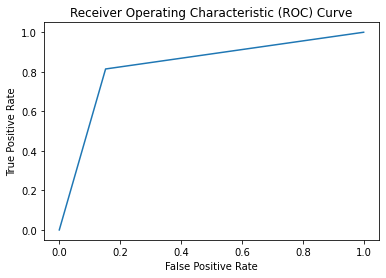

In [38]:
# AUC-ROC graph ----------------------------------------

fpr, tpr, thresholds = roc_curve(target_test, predictions)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()

<div class="alert alert-block alert-success">
<b>Comentario de Revisor - 2da ITERACION</b> <a class="tocSkip"></a>

Manuel es muy bueno tu trabajo en esta iteracion te felicito
</div>

<div class="alert alert-block alert-danger">
<b>Comentario de Revisor - 2da ITERACION</b> <a class="tocSkip"></a>

Solo voy a pedirte 2 cosas mas para que demos por aprobaod el proyecto
    
Documenta al final de la notebook, tus conclusiones respecto a porque performan asi los diferentes modelos para estos datos y elige cual seria el optimo en este caso 
    
**Tip**, el tiempo que tarda en entrenar el modelo juega en esa decision, seria performance vs costo de computo al entrenar el criterio de eleccion)
    
Y por favor, suma algunas otras metricas ademas de AUR ROC como F1 y confusion matrices y alguna visualizacion de las curvas AUC ROC que soporten todo esto
</div>